In [752]:
#En este notebook es donde vamos a proceder a manipular la df que tenemos, de momento vamos a ir importando.

In [753]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [754]:
df = pd.read_csv("../Raw/steam.csv")
df = df.dropna()
#Nota: Dropna solo ha quitado 15 filas, nada de lo que preocuparse.

In [755]:
#tenemos varias columnas que no nos aportan nada interesante, las quitamos.
df = df.drop(["appid", "average_playtime","median_playtime", "owners"], axis=1)

In [756]:

#se ve bien, vamos a empezar ese feature engineering.
#Nuestro target sera la columna de precio, por el momento, la voy a mantener, ya que si hago modficaciones a las filas, quiero al menos que se haga ahi tambien.

In [757]:
#voy a hacer varias DF, primero separare por categorias.
df["porcentage_positivas"] = round(df["positive_ratings"] / (df["positive_ratings"] + df["negative_ratings"]) *100, 2)
df=df[df["price"] < 50]
df=df[df["price"] != 0]
cat_df = df.copy()

In [758]:
len(cat_df["developer"].value_counts())

15350

In [759]:
#por el momento, quitare todo lo que no este relacionado con las categorias, tambien mantendremos las plataformas.
cat_df = cat_df.drop(["release_date", "positive_ratings","negative_ratings","developer", "price"], axis=1)


In [760]:
label_encoder = LabelEncoder()
cat_df["publisher"] = label_encoder.fit_transform(cat_df["publisher"])

In [761]:
cat_df["platforms"].value_counts()

platforms
windows              16552
windows;mac;linux     4276
windows;mac           3074
windows;linux          562
mac                      2
mac;linux                1
Name: count, dtype: int64

In [762]:
#vamos a dividirlos por los sistemas operativos que usan.

op_sys = cat_df['platforms'].str.split(';',expand=True)
#ahora les cambio el nombre, para tenerlas bien organizadas.
op_sys.columns = ["windows","mac","linux"]
#vamos a tener Nones, que se tratan como Nan
op_sys.fillna(0, inplace=True)

In [763]:
def cambiar_texto(df, columna, antes, despues):
    if type(columna) == str or type(antes) == str or type(despues) == str:
        df[columna] = df[columna].str.replace(antes, despues)
        return df
    else:
        print("por favor, pasa los datos correctamente.")

In [764]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
windows    24464
mac            3
Name: count, dtype: int64
mac
0        16554
mac       7350
linux      563
Name: count, dtype: int64
linux
0        20191
linux     4276
Name: count, dtype: int64


In [765]:
#op_sys = cambiar_texto(op_sys, "windows", "windows","1")
op_sys["windows"].value_counts()

#parece que se ha equivocado con los valores, vamos a arreglarlo.
#Linux parece no tener malos valores, como estaba mas a la derecha, vamos con mac directamente y metemos los valores que le falten a Linux
#Para no comerme posibles valores, primero haremos de mac a linux, y luego de windows al resto.

op_sys.loc[op_sys['mac'] == 'linux', 'linux'] = "linux"
op_sys.loc[op_sys['mac'] == 'linux'] = 0

#ahora windows

op_sys.loc[op_sys['windows'] == 'linux', 'linux'] = "linux"
op_sys.loc[op_sys['windows'] == 'mac', 'mac'] = "mac"
op_sys.loc[op_sys['windows'] != 'windows'] = 0


In [766]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
windows    23902
0            565
Name: count, dtype: int64
mac
0      17117
mac     7350
Name: count, dtype: int64
linux
0        20191
linux     4276
Name: count, dtype: int64


In [767]:
#ahora podemos cambiar el texto.
op_sys = cambiar_texto(op_sys, "windows", "windows","1")
op_sys = cambiar_texto(op_sys, "linux", "linux","1")
op_sys = cambiar_texto(op_sys, "mac", "mac","1")

In [768]:
#vamos a tener Nones, que se tratan como Nan
op_sys.fillna(0, inplace=True)

In [769]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
1    23902
0      565
Name: count, dtype: int64
mac
0    17117
1     7350
Name: count, dtype: int64
linux
0    20191
1     4276
Name: count, dtype: int64


In [770]:
op_sys
#esta perfecta.

,windows,mac,linux
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,1,0,0
27071,1,0,0
27072,1,0,0
27073,1,1,0


In [771]:
#Metemos las 3 nuevas que he creado.

cat_df = pd.concat([cat_df, op_sys], axis=1)

cat_df

,name,english,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,porcentage_positivas,windows,mac,linux
0,Counter-Strike,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,97.39,1,1,1
1,Team Fortress Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,83.98,1,1,1
2,Day of Defeat,1,11199,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,89.56,1,1,1
3,Deathmatch Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,82.66,1,1,1
4,Half-Life: Opposing Force,1,11199,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,94.80,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,1,9079,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,100.00,1,0,0
27071,Cyber Gun,1,1239,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,88.89,1,0,0
27072,Super Star Blast,1,3363,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0.00,1,0,0
27073,New Yankee 7: Deer Hunters,1,503,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,100.00,1,1,0


In [772]:
#vamos a dividirlos de forma basica, si es multijugador, single player, tiene Anti-cheat...
#mejor, creo una funcion para esto.
def filtrar(df,columna_objetivo, texto, columna_nueva):
    df[columna_nueva] = df[columna_objetivo].apply(lambda x: 1 if texto in x else 0)
    return df

cat_df = filtrar(cat_df, 'categories', 'Multi-player', 'Multi-player')
cat_df = filtrar(cat_df, 'categories', 'Online', 'Online')
cat_df = filtrar(cat_df, 'categories', 'Single-player', 'Single-player')
cat_df = filtrar(cat_df, 'categories', 'Anti-Cheat', 'Anti-Cheat')

In [773]:
#para genre, vamos a ponerles solo el primero que tengan, luego lo convertiremos con label encoder

def primero(df, columna):

    generos = df[columna].str.split(';',expand=True)
    df[columna] = generos[0]
    return df

In [774]:
cat_df = primero(cat_df, "genres")

In [775]:
cat_df["genres"].value_counts()
#me gusta, tiene de todo y eso esta bien, por el momento.
#para la realizacion de este trabajo, se cogeran las superiores a 300

genres
Action                   10289
Adventure                 4810
Casual                    3917
Indie                     2514
Violent                    652
Simulation                 580
Strategy                   504
RPG                        393
Sexual Content             222
Racing                     187
Nudity                     103
Gore                        76
Sports                      74
Animation & Modeling        48
Utilities                   32
Design & Illustration       19
Audio Production            14
Massively Multiplayer       11
Education                    8
Early Access                 8
Free to Play                 2
Web Publishing               1
Photo Editing                1
Accounting                   1
Video Production             1
Name: count, dtype: int64

In [776]:
tags = cat_df["steamspy_tags"].str.split(';',expand=True)
tags[2].value_counts()
#no puedo usar esto, tiene demasiadas filas, si hiciese un get dummies acabaria con 300 columnas y eso no ayudaria.
#segun el ejercicio del cancer, no pasa nada si tengo 30 columnas...
#vamos a hacer una prueba, vamos a hacer una nueva DF y cogemos solo los mas comunes

2
Indie         3852
Casual        2430
Adventure     1740
Action        1291
Simulation    1099
              ... 
Bowling          1
America          1
Skating          1
Tennis           1
Logic            1
Name: count, Length: 320, dtype: int64

In [777]:
testeo = cat_df.copy()
testeo = filtrar(testeo, 'steamspy_tags', 'Indie', 'Indie')
testeo = filtrar(testeo, 'steamspy_tags', 'Action', 'Action')
testeo = filtrar(testeo, 'steamspy_tags', 'Adventure', 'Adventure')
testeo = filtrar(testeo, 'steamspy_tags', 'Casual', 'Casual')
testeo = filtrar(testeo, 'steamspy_tags', 'Strategy', 'Strategy')
testeo = filtrar(testeo, 'steamspy_tags', 'Simulation', 'Simulation')

In [778]:
cat_df

,name,english,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat
0,Counter-Strike,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,97.39,1,1,1,1,1,0,1
1,Team Fortress Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,83.98,1,1,1,1,1,0,1
2,Day of Defeat,1,11199,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,89.56,1,1,1,1,0,0,1
3,Deathmatch Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,82.66,1,1,1,1,1,0,1
4,Half-Life: Opposing Force,1,11199,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,94.80,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,1,9079,windows,0,Single-player;Steam Achievements,Adventure,Adventure;Indie;Casual,7,100.00,1,0,0,0,0,1,0
27071,Cyber Gun,1,1239,windows,0,Single-player,Action,Action;Indie;Adventure,0,88.89,1,0,0,0,0,1,0
27072,Super Star Blast,1,3363,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action,Action;Indie;Casual,24,0.00,1,0,0,1,0,1,0
27073,New Yankee 7: Deer Hunters,1,503,windows;mac,0,Single-player;Steam Cloud,Adventure,Indie;Casual;Adventure,0,100.00,1,1,0,0,0,1,0


In [779]:
test = pd.concat([testeo, df["price"]], axis=1)
test = test.drop(["name","english", "platforms", "categories", "genres", "steamspy_tags"],axis=1)

In [780]:
test

,publisher,required_age,achievements,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat,Indie,Action,Adventure,Casual,Strategy,Simulation,price
0,11199,0,0,97.39,1,1,1,1,1,0,1,0,1,0,0,0,0,7.19
1,11199,0,0,83.98,1,1,1,1,1,0,1,0,1,0,0,0,0,3.99
2,11199,0,0,89.56,1,1,1,1,0,0,1,0,0,0,0,0,0,3.99
3,11199,0,0,82.66,1,1,1,1,1,0,1,0,1,0,0,0,0,3.99
4,11199,0,0,94.80,1,1,1,1,0,1,1,0,1,0,0,0,0,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,9079,0,7,100.00,1,0,0,0,0,1,0,1,0,1,1,0,0,2.09
27071,1239,0,0,88.89,1,0,0,0,0,1,0,1,1,1,0,0,0,1.69
27072,3363,0,24,0.00,1,0,0,1,0,1,0,1,1,0,1,0,0,3.99
27073,503,0,0,100.00,1,1,0,0,0,1,0,1,0,1,1,0,0,5.19


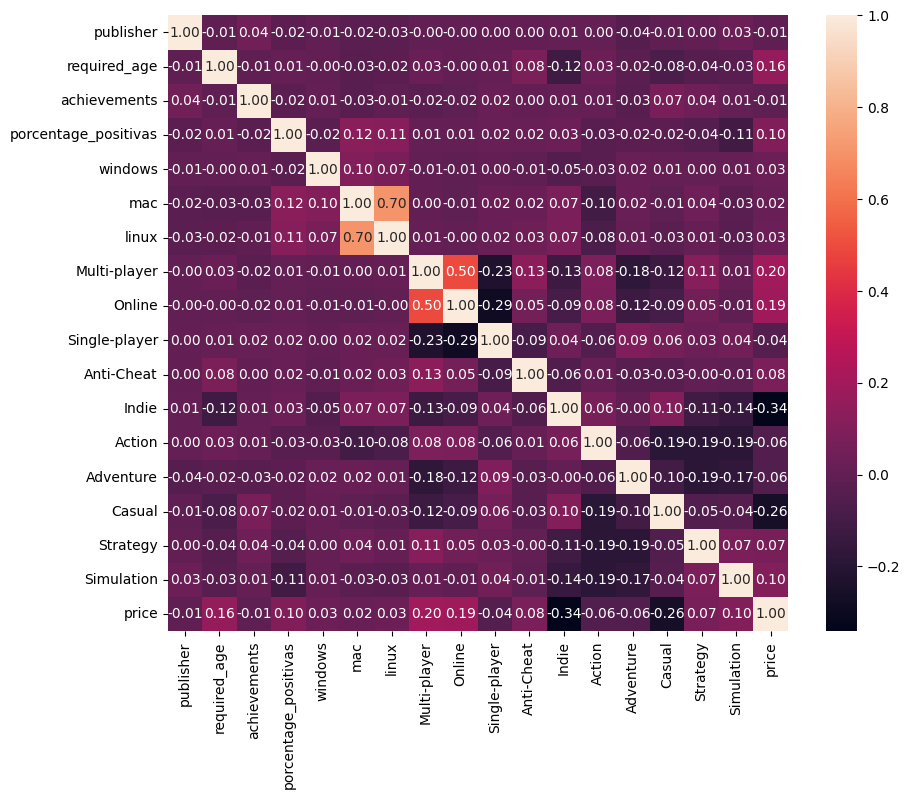

In [781]:
#vamos a hacer un pairplot y un heatmap, a ver que sale.
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, fmt=".2f");

In [782]:
#sns.pairplot(test,hue="price");

In [783]:
#al fin y al cabo, son variables de 0 y 1, es normal que me salga esto.
#Ahora, segun veo en el heatmap, casual y indie influyen bastante en el precio.
#solo mantendremos esas 2 columnas.

In [784]:
cat_df = pd.concat([cat_df,test["Indie"], test["Casual"], df["price"]],axis=1)
test = cat_df.drop(["name","english", "platforms", "categories", "genres", "steamspy_tags", "price"],axis=1)
test
#por el momento, se quedara asi,

,publisher,required_age,achievements,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat,Indie,Casual
0,11199,0,0,97.39,1,1,1,1,1,0,1,0,0
1,11199,0,0,83.98,1,1,1,1,1,0,1,0,0
2,11199,0,0,89.56,1,1,1,1,0,0,1,0,0
3,11199,0,0,82.66,1,1,1,1,1,0,1,0,0
4,11199,0,0,94.80,1,1,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,9079,0,7,100.00,1,0,0,0,0,1,0,1,1
27071,1239,0,0,88.89,1,0,0,0,0,1,0,1,0
27072,3363,0,24,0.00,1,0,0,1,0,1,0,1,1
27073,503,0,0,100.00,1,1,0,0,0,1,0,1,1


In [785]:
#vamos a probar una regresion lineal, ya tenemos nuestra X e y
def regression(df, target):
    df = df.select_dtypes(exclude=['object'])
    model = LinearRegression()

    X = df
    y = target

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

    model.fit(X_train,y_train)

    pred = model.predict(X_test)

    print("Media Target: ", y.mean())
    print("Intercept: ",model.intercept_)
    print("Model: ", model.coef_)
    print("R2", round(r2_score(y_test, pred),3))
    print("MAE", round(mean_absolute_error(y_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(y_test, pred),3))
    print("MSE", round(mean_squared_error(y_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(y_test, pred)),3))

In [786]:
regression(test, df["price"])

Media Target:  6.562907589814853
Intercept:  6.621314983199839
Model:  [-1.14415938e-05  2.63093461e-01  1.88930690e-04  2.65004577e-02
  1.48055634e+00  2.60646362e+00  8.86115266e-01  3.85818440e+00
 -3.82066212e+00 -2.81973601e+00]
R2 0.216
MAE 3.858
MAPE 1.242
MSE 31.852
RMSE 5.644


In [787]:
#cuanto es la media de precio? a ver.

df["price"].mean()

6.562907589814853

In [788]:
#es un modelo realmente simple y no esta nada mal el resultado.
#de momento, este modelo se queda asi, buscaremos mas adelante un modelo para optimizar al maximo posible.

In [789]:
generos = cat_df["genres"].value_counts().head(8)
generos = dict(generos)
generos = list(generos.keys())
generos

['Action',
 'Adventure',
 'Casual',
 'Indie',
 'Violent',
 'Simulation',
 'Strategy',
 'RPG']

In [790]:
action = cat_df[cat_df["genres"] == generos[0]]
adventure = cat_df[cat_df["genres"] == generos[1]]
casual = cat_df[cat_df["genres"] == generos[2]]
indie = cat_df[cat_df["genres"] == generos[3]]
violent = cat_df[cat_df["genres"] == generos[4]]
simulation = cat_df[cat_df["genres"] == generos[5]]
strategy = cat_df[cat_df["genres"] == generos[6]]
rpg = cat_df[cat_df["genres"] == generos[7]]

In [791]:
adventure.reset_index(inplace=True)
adventure = adventure.drop(["index"], axis=1)
casual.reset_index(inplace=True)
casual = casual.drop(["index"], axis=1)
indie.reset_index(inplace=True)
indie = indie.drop(["index"], axis=1)
violent.reset_index(inplace=True)
violent = violent.drop(["index"], axis=1)
simulation.reset_index(inplace=True)
simulation = simulation.drop(["index"], axis=1)
strategy.reset_index(inplace=True)
strategy = strategy.drop(["index"], axis=1)
rpg.reset_index(inplace=True)
rpg = rpg.drop(["index"], axis=1)

In [792]:
action.dtypes

name                     object
english                   int64
publisher                 int32
platforms                object
required_age              int64
categories               object
genres                   object
steamspy_tags            object
achievements              int64
porcentage_positivas    float64
windows                  object
mac                      object
linux                    object
Multi-player              int64
Online                    int64
Single-player             int64
Anti-Cheat                int64
Indie                     int64
Casual                    int64
price                   float64
dtype: object

In [793]:
regression(action.drop(["price"], axis=1), action["price"])

Media Target:  6.618996015161824
Intercept:  3.6566419236020615
Model:  [ 2.11791109e+00 -3.43783171e-05  3.37547158e-01  3.75795500e-04
  3.06813645e-02  1.11328296e+00  2.75228884e+00  1.05237300e+00
  2.59191543e+00 -3.56838856e+00 -2.66825501e+00]
R2 0.23
MAE 3.854
MAPE 1.274
MSE 32.025
RMSE 5.659


In [794]:
regression(adventure.drop(["price"], axis=1), adventure["price"])

Media Target:  6.239796257796257
Intercept:  3.9621088313067405
Model:  [ 1.11437858e+00  3.63132770e-06  2.74610959e-01 -5.91217917e-04
  3.52797072e-02  4.72729087e-01  2.64390314e+00  9.94768930e-01
  3.46455033e+00 -2.91610432e+00 -2.07952217e+00]
R2 0.177
MAE 3.37
MAPE 1.097
MSE 23.847
RMSE 4.883


In [795]:
regression(casual.drop(["price"], axis=1), casual["price"])

Media Target:  4.035711003318866
Intercept:  6.199673409598144
Model:  [ 1.30565846e+00  2.29222966e-05  6.05998469e-02  7.06477382e-06
  1.19290119e-02  1.13895345e+00  1.29554005e+00 -2.21889772e-01
  4.01345541e+00 -1.95945767e+00 -3.18775759e+00]
R2 0.161
MAE 2.443
MAPE 1.2
MSE 12.816
RMSE 3.58


In [796]:
regression(indie.drop(["price"], axis=1), indie["price"])

Media Target:  6.9024940334128875
Intercept:  10.252918087959406
Model:  [ 6.16996797e-01 -9.77537578e-06 -3.75713840e-02 -6.44826311e-04
  1.67921015e-02  1.79933361e+00  1.65687820e+00  5.03133043e-01
 -8.63438525e+00 -6.76414394e+00 -1.65838975e+00]
R2 0.211
MAE 3.687
MAPE 1.33
MSE 23.581
RMSE 4.856


In [797]:
regression(violent.drop(["price"], axis=1), violent["price"])

Media Target:  6.340030674846625
Intercept:  5.80766850864884
Model:  [-4.74492131e+00 -5.55044849e-06  3.98117771e-01 -9.67636684e-04
  2.45224634e-02 -1.85387590e+00  5.71374577e+00  4.38771684e+00
 -3.10862447e-15 -2.36714382e+00 -1.45326734e+00]
R2 0.204
MAE 4.3
MAPE 1.246
MSE 40.998
RMSE 6.403


In [798]:
regression(simulation.drop(["price"], axis=1), simulation["price"])

Media Target:  12.235706896551724
Intercept:  17.79019548984049
Model:  [-3.33369714e+00 -1.23134994e-04  1.30487289e-01  4.11494273e-02
  3.98306734e-02  6.94885348e+00  2.55048237e+00 -6.20336793e+00
  4.53109772e-14 -4.61794249e+00 -2.96814777e-01]
R2 0.06
MAE 6.181
MAPE 1.123
MSE 61.955
RMSE 7.871


In [799]:
regression(strategy.drop(["price"], axis=1), strategy["price"])

Media Target:  10.625496031746032
Intercept:  11.919368688842335
Model:  [-8.89546338e+00  3.91951211e-04 -1.68437555e-01  5.84631815e-02
 -3.54515893e-02  3.30484785e+00  1.18697985e+00  4.93476745e+00
  4.06459594e+00 -3.87151303e+00 -2.97304290e+00]
R2 0.252
MAE 5.188
MAPE 0.772
MSE 52.772
RMSE 7.264


In [800]:
regression(rpg.drop(["price"], axis=1), rpg["price"])

Media Target:  12.064503816793891
Intercept:  14.872242653097121
Model:  [ 1.30078797e+00  2.49570556e-04  3.18728331e-01 -5.16100207e-04
  9.69585638e-02  1.39507013e+00  3.99486984e+00 -1.32019699e+01
 -7.16372022e+00 -7.84713551e+00  3.06738634e+00]
R2 0.103
MAE 7.684
MAPE 1.757
MSE 91.975
RMSE 9.59


In [801]:
def guardar_csv(data):
    nombre = str(data["genres"][0]) +".csv"
    df.to_csv(f"../limpiado/{nombre}")


In [802]:
action["genres"]

0        Action
1        Action
2        Action
3        Action
4        Action
          ...  
27062    Action
27063    Action
27065    Action
27071    Action
27072    Action
Name: genres, Length: 10289, dtype: object

In [803]:
guardar_csv(action)
guardar_csv(adventure)
guardar_csv(casual)
guardar_csv(indie)
guardar_csv(simulation)
guardar_csv(strategy)
guardar_csv(violent)
guardar_csv(rpg)